# Import

In [12]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 設置繁體中文字型
rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體
rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# Data

In [13]:

# 下載VXX數據
vxx = yf.download("VXX", start="2019-01-01", end="2024-12-30")
vxx


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3102.080078,3123.072021,2908.159912,2927.360107,2927.360107,32108
2019-01-03,2982.399902,3114.239990,2962.560059,3048.959961,3048.959961,15936
2019-01-04,2931.840088,2945.919922,2798.719971,2807.040039,2807.040039,20398
2019-01-07,2785.919922,2825.087891,2710.399902,2744.320068,2744.320068,40055
2019-01-08,2696.959961,2791.679932,2680.320068,2688.639893,2688.639893,14770
...,...,...,...,...,...,...
2024-12-20,55.820000,55.980000,47.625000,48.080002,48.080002,10973900
2024-12-23,46.919998,48.820000,44.380001,44.380001,44.380001,4045900
2024-12-24,43.970001,44.049999,42.180000,42.279999,42.279999,2884300


# Def

In [14]:
class VIXBollingerStrategy:
    def __init__(self, data, period=20):
        """
        初始化布林帶策略
        :param data: VIX期貨數據
        :param period: 布林帶周期
        """
        self.data = data.copy()
        self.period = period
        
    def calculate_bollinger_bands(self):
        """計算布林帶"""
        # 計算移動平均線
        self.data['MA'] = self.data['Close'].rolling(window=self.period).mean()
        # 計算標準差
        rolling_std = self.data['Close'].rolling(window=self.period).std()
        
        # 計算布林帶（1個標準差和2個標準差）
        self.data['Upper_Band1'] = self.data['MA'] + rolling_std
        self.data['Lower_Band1'] = self.data['MA'] - rolling_std
        self.data['Upper_Band2'] = self.data['MA'] + 2 * rolling_std
        self.data['Lower_Band2'] = self.data['MA'] - 2 * rolling_std
        
        return self.data
    
    def calculate_signals(self):
        """計算交易信號"""
        # 初始化信號和倉位
        self.data['Signal'] = 0  # 信號欄位用於記錄當天產生的交易信號
        self.data['Position'] = 0  # 倉位欄位用於記錄實際持倉狀態
        
        # 初始化TP和SL信號欄位
        self.data['TPSLSignal'] = ''  # 用於記錄止盈止損信號
        
        # 多頭信號條件：從下往上突破第一條布林線上軌（1個標準差）
        long_signal = (self.data['Close'] > self.data['Upper_Band1']) & \
                    (self.data['Close'].shift(1) <= self.data['Upper_Band1'].shift(1))
        
        # 空頭信號條件：從上往下突破第一條布林線下軌（1個標準差）
        short_signal = (self.data['Close'] < self.data['Lower_Band1']) & \
                    (self.data['Close'].shift(1) >= self.data['Lower_Band1'].shift(1))
        
        # 設置進場信號
        self.data.loc[long_signal, 'Signal'] = 1
        self.data.loc[short_signal, 'Signal'] = -1
        
        # 遍歷數據處理持倉和止盈止損
        current_position = 0
        in_trade = False
        entry_signal = 0
        
        for i in range(1, len(self.data)):
            today = self.data.iloc[i]
            yesterday = self.data.iloc[i-1]
            
            # 如果不在交易中，檢查是否有新信號
            if not in_trade:
                # 檢查前一天的信號（實現隔日交易）
                if yesterday['Signal'] != 0:
                    current_position = yesterday['Signal']
                    entry_signal = yesterday['Signal']
                    in_trade = True
                    self.data.iloc[i, self.data.columns.get_loc('Position')] = current_position
            
            # 如果在交易中，檢查止盈止損條件
            elif in_trade:
                # 檢查多頭止盈止損
                if current_position == 1:
                    # 止盈：達到上軌2個標準差
                    if today['Close'] >= today['Upper_Band2']:
                        self.data.iloc[i, self.data.columns.get_loc('TPSLSignal')] = 'LTP'
                        # 隔日平倉
                        if i + 1 < len(self.data):
                            self.data.iloc[i+1, self.data.columns.get_loc('Position')] = 0
                        in_trade = False
                        current_position = 0
                    # 止損：回落到均線
                    elif today['Close'] <= today['MA']:
                        self.data.iloc[i, self.data.columns.get_loc('TPSLSignal')] = 'LSL'
                        # 隔日平倉
                        if i + 1 < len(self.data):
                            self.data.iloc[i+1, self.data.columns.get_loc('Position')] = 0
                        in_trade = False
                        current_position = 0
                    else:
                        # 維持原有持倉
                        self.data.iloc[i, self.data.columns.get_loc('Position')] = current_position
                
                # 檢查空頭止盈止損
                elif current_position == -1:
                    # 止盈：達到下軌2個標準差
                    if today['Close'] <= today['Lower_Band2']:
                        self.data.iloc[i, self.data.columns.get_loc('TPSLSignal')] = 'STP'
                        # 隔日平倉
                        if i + 1 < len(self.data):
                            self.data.iloc[i+1, self.data.columns.get_loc('Position')] = 0
                        in_trade = False
                        current_position = 0
                    # 止損：回升到均線
                    elif today['Close'] >= today['MA']:
                        self.data.iloc[i, self.data.columns.get_loc('TPSLSignal')] = 'SSL'
                        # 隔日平倉
                        if i + 1 < len(self.data):
                            self.data.iloc[i+1, self.data.columns.get_loc('Position')] = 0
                        in_trade = False
                        current_position = 0
                    else:
                        # 維持原有持倉
                        self.data.iloc[i, self.data.columns.get_loc('Position')] = current_position
        
        return self.data
    
    def backtest(self, initial_capital=100000):
            """
            回測策略
            :param initial_capital: 初始資金
            :return: 回測結果
            """
            # 初始化收益計算
            self.data['Returns'] = 0.0
            self.data['Cumulative_Returns'] = 1.0
            
            # 計算每日收益率
            # 使用開盤價計算收益率
            self.data['Open_Return'] = self.data['Open'].pct_change()
            
            # 只在有倉位時計算收益（使用當天的開盤價）
            self.data['Returns'] = self.data['Open_Return'] * self.data['Position']
            
            # 計算累積收益
            self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
            
            # 計算策略評估指標
            total_days = len(self.data)
            active_days = (self.data['Position'] != 0).sum()
            
            if total_days > 0:
                total_return = self.data['Cumulative_Returns'].iloc[-1] - 1
                annual_return = total_return / (total_days / 252)
                
                trading_returns = self.data['Returns'][self.data['Position'] != 0]
                sharpe_ratio = np.sqrt(252) * (trading_returns.mean() / trading_returns.std()) if len(trading_returns) > 1 else 0
            else:
                total_return = 0
                annual_return = 0
                sharpe_ratio = 0
            
            return {
                'Total Return': total_return,
                'Annual Return': annual_return,
                'Sharpe Ratio': sharpe_ratio,
                'Active Days': active_days,
                'Total Days': total_days
            }


    def plot_strategy(self):
        """繪製策略圖表"""
        plt.figure(figsize=(15, 10))
        
        # 繪製價格和布林帶
        plt.subplot(2, 1, 1)
        plt.plot(self.data.index, self.data['Close'], label='VIX')
        plt.plot(self.data.index, self.data['MA'], label=f'{self.period}日均線', color='gray')
        plt.plot(self.data.index, self.data['Upper_Band1'], 'g--', label='上軌(1σ)')
        plt.plot(self.data.index, self.data['Lower_Band1'], 'g--', label='下軌(1σ)')
        plt.plot(self.data.index, self.data['Upper_Band2'], 'r--', label='上軌(2σ)')
        plt.plot(self.data.index, self.data['Lower_Band2'], 'r--', label='下軌(2σ)')
        
        # 標記交易信號
        # 入場信號
        long_signals = self.data[self.data['Signal'] == 1]
        short_signals = self.data[self.data['Signal'] == -1]
        
        # 出場信號（使用TPSLSignal）
        long_tp = self.data[self.data['TPSLSignal'] == 'LTP']
        long_sl = self.data[self.data['TPSLSignal'] == 'LSL']
        short_tp = self.data[self.data['TPSLSignal'] == 'STP']
        short_sl = self.data[self.data['TPSLSignal'] == 'SSL']
        
        # 繪製各種信號
        plt.scatter(long_signals.index, long_signals['Close'], 
                marker='^', color='g', label='做多信號', s=100)
        plt.scatter(short_signals.index, short_signals['Close'], 
                marker='v', color='r', label='做空信號', s=100)
        
        # 繪製止盈止損點
        plt.scatter(long_tp.index, long_tp['Close'], 
                marker='s', color='g', label='多頭止盈', s=80)
        plt.scatter(long_sl.index, long_sl['Close'], 
                marker='x', color='g', label='多頭止損', s=80)
        plt.scatter(short_tp.index, short_tp['Close'], 
                marker='s', color='r', label='空頭止盈', s=80)
        plt.scatter(short_sl.index, short_sl['Close'], 
                marker='x', color='r', label='空頭止損', s=80)
        
        plt.title('VIX布林帶策略交易信號 (隔日開盤執行)')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        
        # 繪製累積收益
        plt.subplot(2, 1, 2)
        plt.plot(self.data.index, self.data['Cumulative_Returns'], label='策略累積收益')
        plt.title('策略累積收益曲線')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def analyze_trades(self):
        """分析每筆交易的詳細資訊"""
        trades = []
        current_trade = None
        
        # 遍歷每一個交易日
        for i in range(1, len(self.data)):
            today = self.data.iloc[i]
            yesterday = self.data.iloc[i-1]
            
            # 新倉位建立（進場）- 根據Position的變化來判斷
            if today['Position'] != 0 and yesterday['Position'] == 0:
                current_trade = {
                    'entry_time': self.data.index[i],
                    'entry_price': today['Open'],
                    'position': today['Position'],
                    'exit_time': None,
                    'exit_price': None,
                    'exit_type': None,  # 新增：記錄出場類型（TP或SL）
                    'returns': None,
                    'holding_days': None
                }
            
            # 倉位平倉（出場）
            elif today['Position'] == 0 and yesterday['Position'] != 0 and current_trade is not None:
                current_trade['exit_time'] = self.data.index[i]
                current_trade['exit_price'] = today['Open']
                
                # 記錄出場類型
                if yesterday['TPSLSignal']:  # 如果有TP/SL信號
                    current_trade['exit_type'] = yesterday['TPSLSignal']
                
                # 計算報酬率
                if current_trade['position'] == 1:  # 多頭
                    current_trade['returns'] = (current_trade['exit_price'] - current_trade['entry_price']) / current_trade['entry_price']
                else:  # 空頭
                    current_trade['returns'] = (current_trade['entry_price'] - current_trade['exit_price']) / current_trade['entry_price']
                
                # 計算持倉天數
                current_trade['holding_days'] = (current_trade['exit_time'] - current_trade['entry_time']).days
                
                trades.append(current_trade)
                current_trade = None
        
        # 將交易紀錄轉換為DataFrame
        trades_df = pd.DataFrame(trades)
        
        if len(trades_df) > 0:
            # 計算交易統計
            trades_df['profitable'] = trades_df['returns'] > 0
            
            # 計算各類型出場的統計
            exit_types = trades_df['exit_type'].value_counts()
            
            stats = {
                'total_trades': len(trades_df),
                'winning_trades': sum(trades_df['profitable']),
                'losing_trades': sum(~trades_df['profitable']),
                'win_rate': sum(trades_df['profitable']) / len(trades_df),
                'avg_return': trades_df['returns'].mean(),
                'avg_winning_return': trades_df[trades_df['profitable']]['returns'].mean() if any(trades_df['profitable']) else 0,
                'avg_losing_return': trades_df[~trades_df['profitable']]['returns'].mean() if any(~trades_df['profitable']) else 0,
                'avg_holding_days': trades_df['holding_days'].mean(),
                'max_return': trades_df['returns'].max(),
                'min_return': trades_df['returns'].min(),
                'total_return': (1 + trades_df['returns']).prod() - 1,
                'exit_types': exit_types  # 新增：各類型出場次數
            }
            
            return trades_df, stats
        else:
            return pd.DataFrame(), {}

    def print_trade_analysis(self):
        """打印交易分析報告"""
        trades_df, stats = self.analyze_trades()
        
        if len(trades_df) > 0:
            print("\n=== 交易統計摘要 ===")
            print(f"總交易次數: {stats['total_trades']}")
            print(f"獲利交易: {stats['winning_trades']}")
            print(f"虧損交易: {stats['losing_trades']}")
            print(f"勝率: {stats['win_rate']:.2%}")
            print(f"平均報酬率: {stats['avg_return']:.2%}")
            print(f"平均獲利交易報酬率: {stats['avg_winning_return']:.2%}")
            print(f"平均虧損交易報酬率: {stats['avg_losing_return']:.2%}")
            print(f"平均持倉天數: {stats['avg_holding_days']:.1f}")
            print(f"最大單筆獲利: {stats['max_return']:.2%}")
            print(f"最大單筆虧損: {stats['min_return']:.2%}")
            print(f"總報酬率: {stats['total_return']:.2%}")
            
            # 新增：打印出場類型統計
            print("\n出場類型統計:")
            for exit_type, count in stats['exit_types'].items():
                print(f"{exit_type}: {count}次")
            
            print("\n=== 詳細交易記錄 ===")
            trades_df['position_type'] = trades_df['position'].map({1: '做多', -1: '做空'})
            trades_df['returns_pct'] = trades_df['returns'].map('{:.2%}'.format)
            
            print_df = trades_df[[
                'entry_time', 'position_type', 'entry_price', 
                'exit_time', 'exit_price', 'exit_type',  # 新增exit_type
                'holding_days', 'returns_pct'
            ]].rename(columns={
                'entry_time': '進場時間',
                'position_type': '部位',
                'entry_price': '進場價格',
                'exit_time': '出場時間',
                'exit_price': '出場價格',
                'exit_type': '出場類型',
                'holding_days': '持倉天數',
                'returns_pct': '報酬率'
            })
            
            print(print_df.to_string())
            
            return trades_df, stats
        else:
            print("沒有找到任何交易記錄")
            return pd.DataFrame(), {}
    
    def ckeck_strategy(self):
        """檢查策略"""
        return self.data

In [15]:
def check(vxx_data, period=20):
    # 初始化策略
    strategy = VIXBollingerStrategy(vxx_data, period=period)
    # 計算布林帶
    strategy.calculate_bollinger_bands()
    # 計算交易信號
    strategy.calculate_signals()
    # 回測
    strategy.backtest()

    df = strategy.ckeck_strategy()

    return df

In [16]:
def run_strategy(vix_data, period=20):
    strategy = VIXBollingerStrategy(vix_data, period=period)
    strategy.calculate_bollinger_bands()
    strategy.calculate_signals()
    results = strategy.backtest()
    strategy.plot_strategy()
    print(f"\n{period}日布林帶策略回測結果:", results)
    print("\n=== 詳細交易分析 ===")
    trades_df, trade_stats = strategy.print_trade_analysis()
    return strategy, trades_df, trade_stats

# Backtest

In [17]:
df = check(vxx, period=20)
df.to_csv('vxx_bollinger.csv')

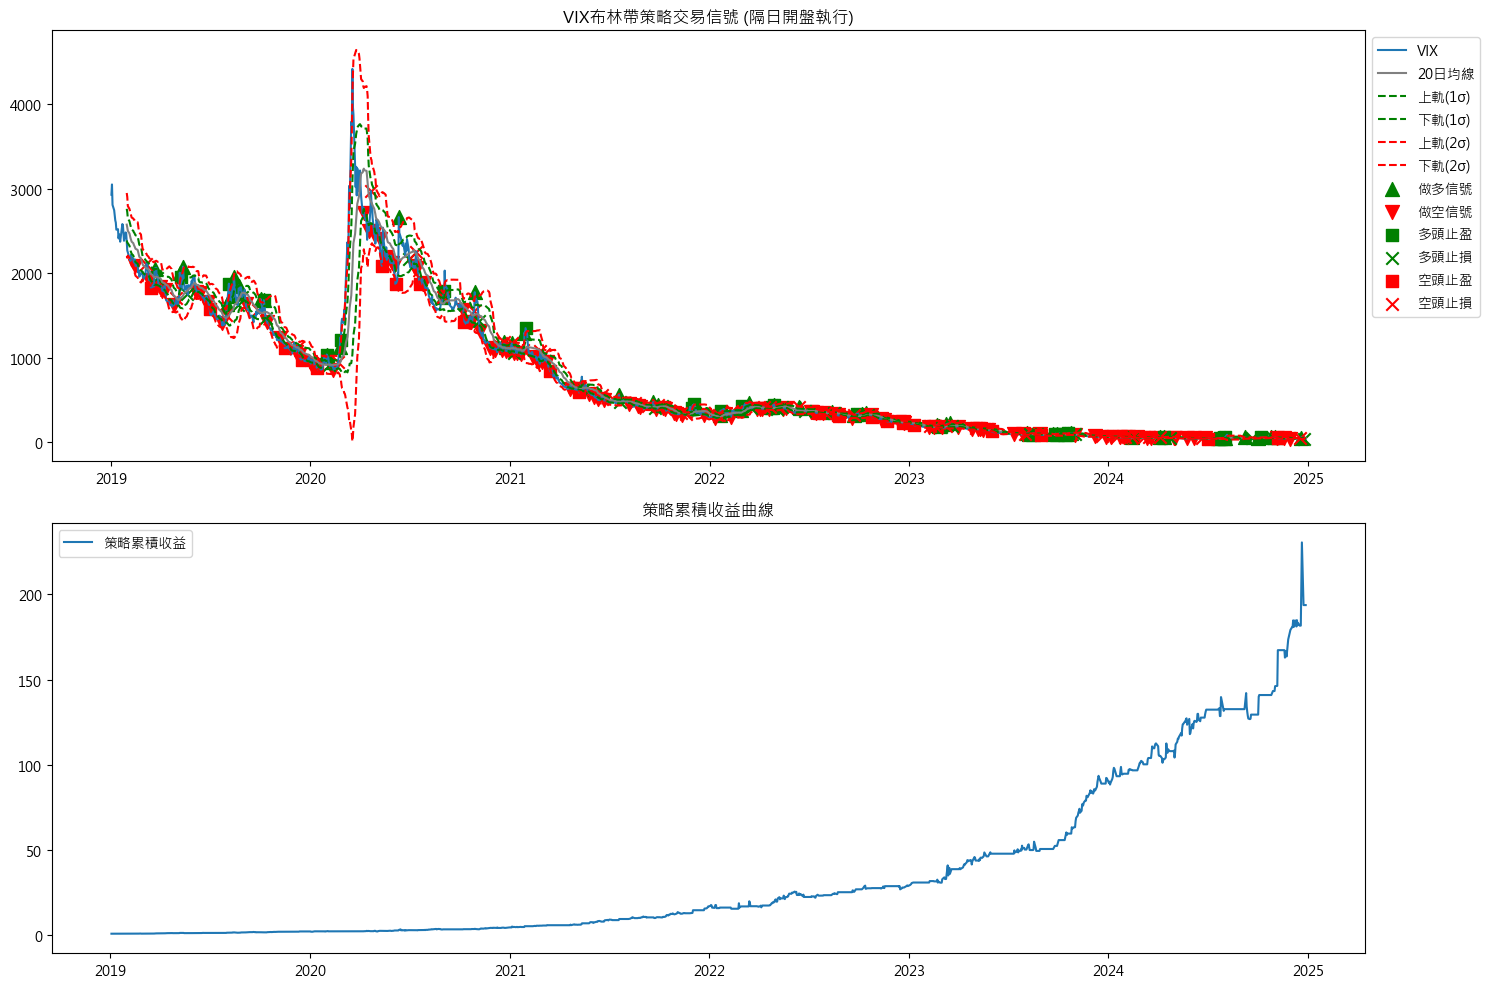


20日布林帶策略回測結果: {'Total Return': 192.78156752121689, 'Annual Return': 32.21548741070733, 'Sharpe Ratio': 3.3910275738815363, 'Active Days': 724, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 120
獲利交易: 60
虧損交易: 60
勝率: 50.00%
平均報酬率: 0.23%
平均獲利交易報酬率: 5.58%
平均虧損交易報酬率: -5.12%
平均持倉天數: 8.6
最大單筆獲利: 25.51%
最大單筆虧損: -14.28%
總報酬率: -0.69%

出場類型統計:

=== 詳細交易記錄 ===
          進場時間  部位         進場價格       出場時間         出場價格  出場類型  持倉天數      報酬率
0   2019-02-19  做空  2122.879883 2019-03-07  2059.520020  None    16    2.98%
1   2019-03-13  做空  1903.359985 2019-03-15  1856.000000  None     2    2.49%
2   2019-03-25  做多  2056.959961 2019-03-26  1971.199951  None     1   -4.17%
3   2019-04-02  做空  1845.760010 2019-05-01  1624.959961  None    29   11.96%
4   2019-05-08  做多  1983.359985 2019-05-09  2073.600098  None     1    4.55%
5   2019-05-14  做多  1999.359985 2019-05-21  1792.000000  None     7  -10.37%
6   2019-06-07  做空  1777.280029 2019-07-01  1571.199951  None    24   11.60%
7   2019-07-24  做空 

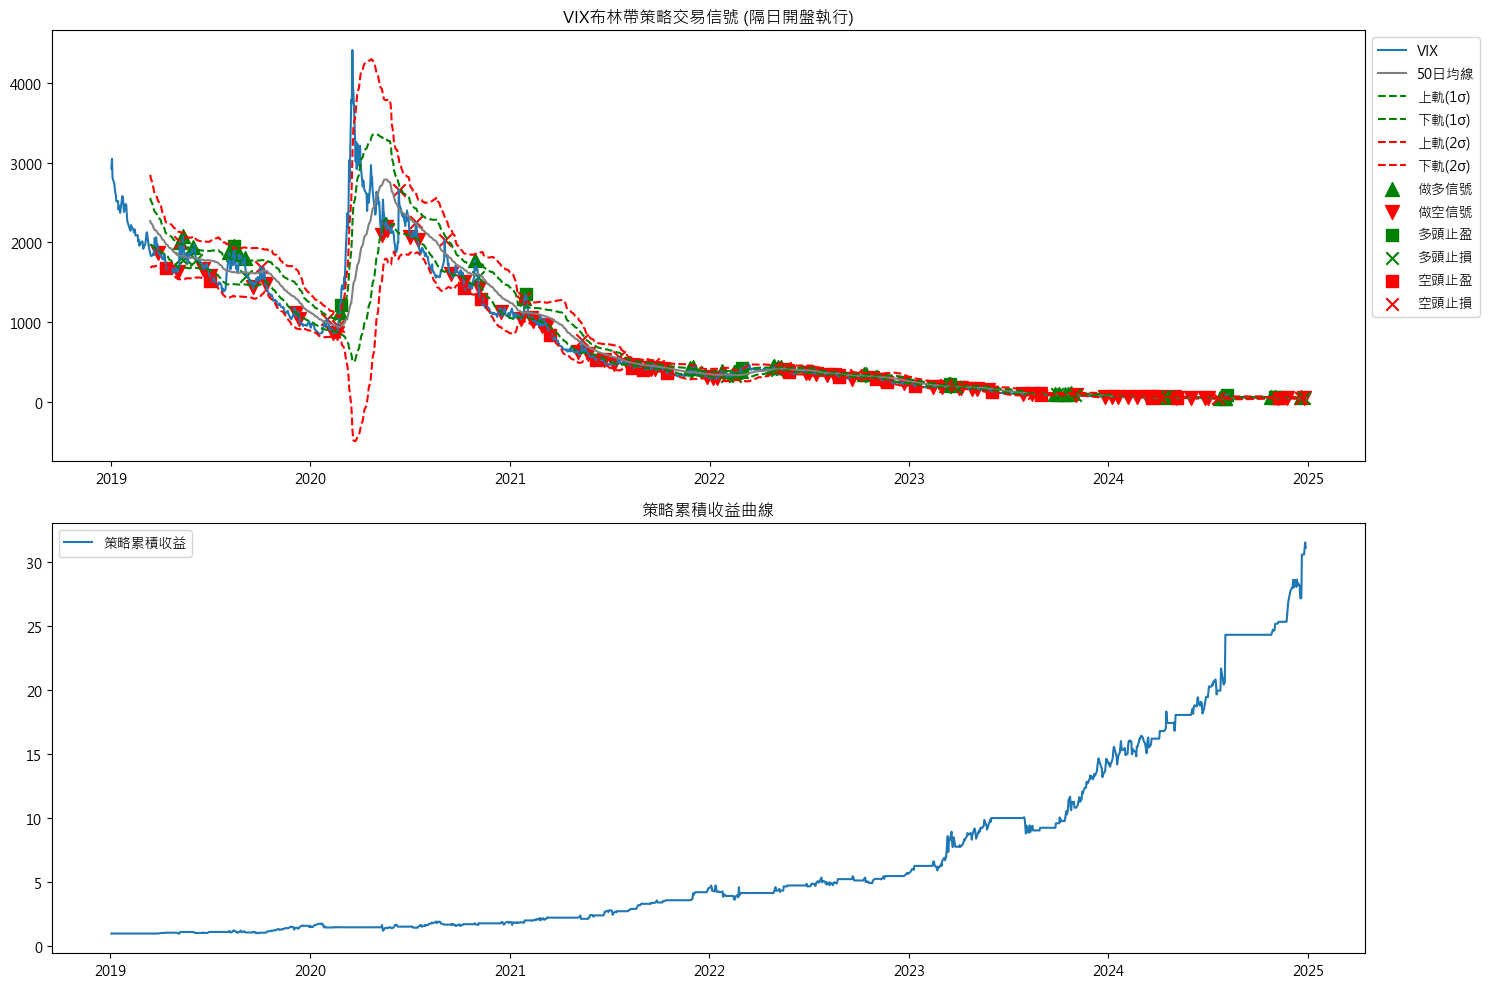


50日布林帶策略回測結果: {'Total Return': 30.13621838946347, 'Annual Return': 5.036025884711402, 'Sharpe Ratio': 2.3099827540558318, 'Active Days': 705, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 65
獲利交易: 34
虧損交易: 31
勝率: 52.31%
平均報酬率: 1.74%
平均獲利交易報酬率: 10.18%
平均虧損交易報酬率: -7.52%
平均持倉天數: 15.5
最大單筆獲利: 65.41%
最大單筆虧損: -17.05%
總報酬率: 88.20%

出場類型統計:

=== 詳細交易記錄 ===
         進場時間  部位         進場價格       出場時間         出場價格  出場類型  持倉天數      報酬率
0  2019-04-01  做空  1854.079956 2019-04-12  1724.800049  None    11    6.97%
1  2019-05-06  做空  1789.439941 2019-05-07  1818.239990  None     1   -1.61%
2  2019-05-08  做多  1983.359985 2019-05-10  1976.319946  None     2   -0.35%
3  2019-05-14  做多  1999.359985 2019-05-16  1864.319946  None     2   -6.75%
4  2019-06-03  做多  1945.599976 2019-06-06  1807.359985  None     3   -7.11%
5  2019-06-20  做空  1629.439941 2019-07-02  1574.400024  None    12    3.38%
6  2019-08-06  做多  1806.079956 2019-08-14  1829.760010  None     8    1.31%
7  2019-08-15  做多  1902.079

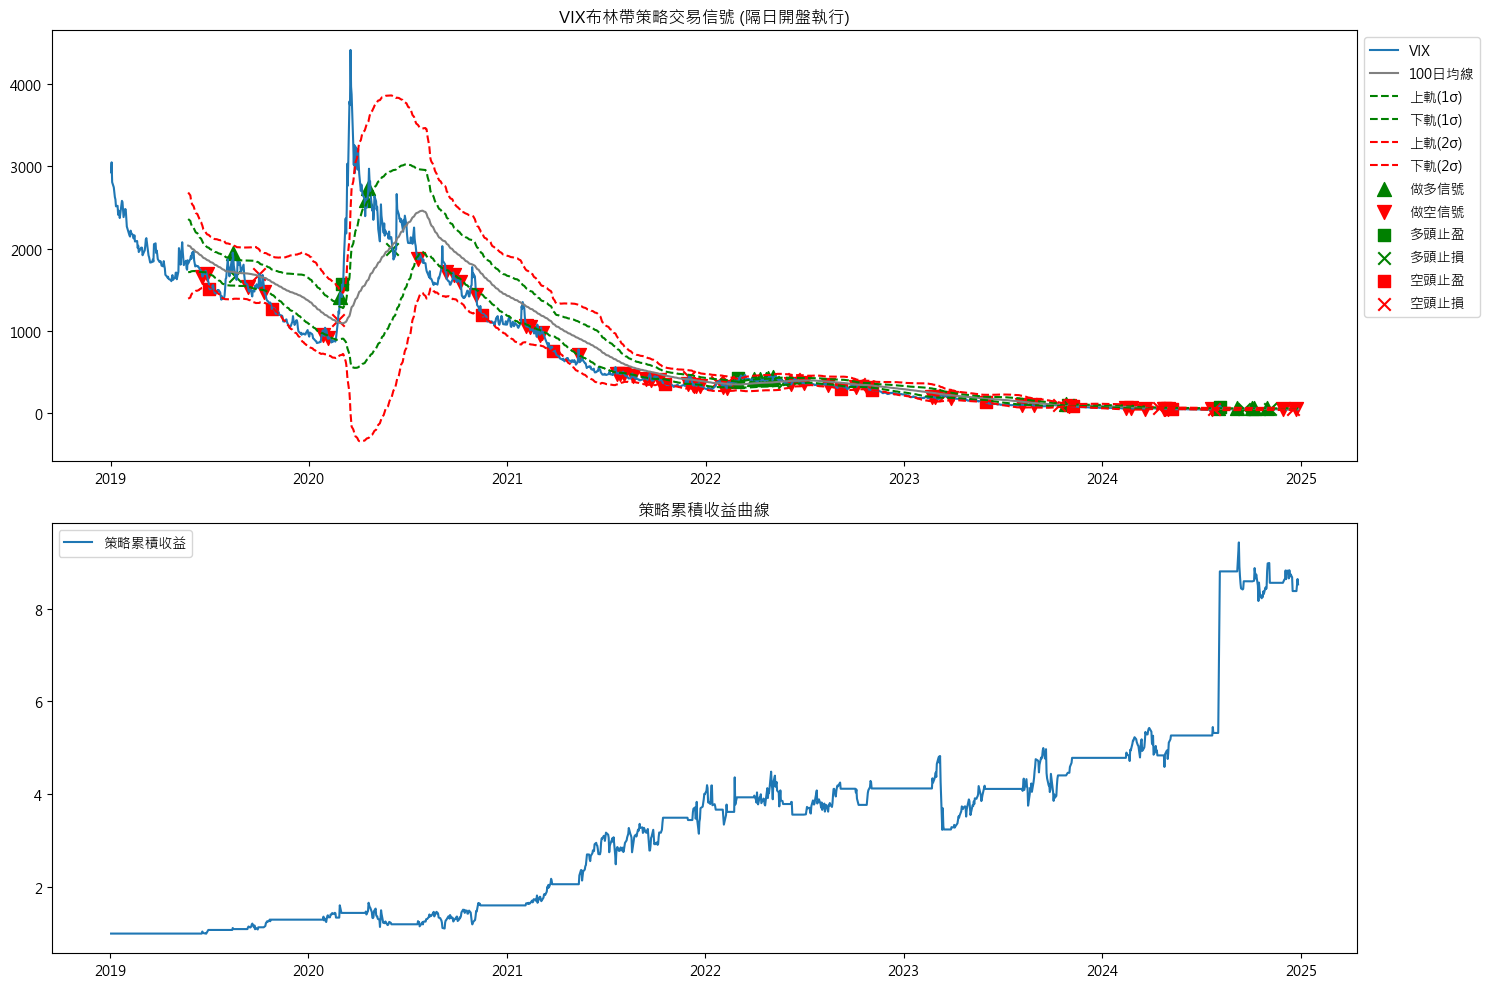


100日布林帶策略回測結果: {'Total Return': 7.52180819634744, 'Annual Return': 1.2569599903710575, 'Sharpe Ratio': 1.4285586089637368, 'Active Days': 653, 'Total Days': 1508}

=== 詳細交易分析 ===

=== 交易統計摘要 ===
總交易次數: 31
獲利交易: 13
虧損交易: 18
勝率: 41.94%
平均報酬率: 1.02%
平均獲利交易報酬率: 15.90%
平均虧損交易報酬率: -9.73%
平均持倉天數: 30.2
最大單筆獲利: 44.18%
最大單筆虧損: -21.94%
總報酬率: -3.62%

出場類型統計:

=== 詳細交易記錄 ===
         進場時間  部位         進場價格       出場時間         出場價格  出場類型  持倉天數      報酬率
0  2019-06-20  做空  1629.439941 2019-07-02  1574.400024  None    12    3.38%
1  2019-08-15  做多  1902.079956 2019-08-19  1718.400024  None     4   -9.66%
2  2019-09-12  做空  1508.479980 2019-10-02  1630.719971  None    20   -8.10%
3  2019-10-14  做空  1478.400024 2019-10-25  1316.479980  None    11   10.95%
4  2020-01-29  做空   932.479980 2020-02-24  1098.239990  None    26  -17.78%
5  2020-02-28  做多  1581.439941 2020-03-03  1404.800049  None     4  -11.17%
6  2020-04-16  做多  2613.760010 2020-06-03  2040.319946  None    48  -21.94%
7  2020-07-21  做空  1824.00

In [18]:

# 對多個週期進行回測
periods = [20, 50, 100]
strategies = {}
trades_records = {}
for period in periods:
    strategies[period], trades_records[period], _ = run_strategy(vxx, period)

# V2 test

In [19]:
test_df = vxx.copy()


# 布林通道
test_df['MA20'] = test_df['Close'].rolling(window=20).mean()
test_df['std20'] = test_df['Close'].rolling(window=20).std()
test_df['Upper_1'] = test_df['MA20'] + test_df['std20']
test_df['Upper_2'] = test_df['MA20'] + 2 * test_df['std20']
test_df['Lower_1'] = test_df['MA20'] - test_df['std20'] 
test_df['Lower_2'] = test_df['MA20'] - 2 * test_df['std20']
test_df.dropna(inplace=True)

test_df

,Open,High,Low,Close,Adj Close,Volume,MA20,std20,Upper_1,Upper_2,Lower_1,Lower_2
Date,,,,,,,,,,,,
2019-01-30,2433.919922,2478.080078,2360.959961,2365.439941,2365.439941,327552,2573.664001,187.202187,2760.866189,2948.068376,2386.461814,2199.259627
2019-01-31,2361.600098,2362.879883,2267.520020,2267.520020,2267.520020,345211,2540.671997,179.575856,2720.247853,2899.823709,2361.096141,2181.520285
2019-02-01,2261.120117,2281.600098,2233.600098,2245.760010,2245.760010,390572,2500.512000,146.729646,2647.241646,2793.971292,2353.782353,2207.052707
2019-02-04,2235.520020,2250.239990,2165.760010,2176.000000,2176.000000,288778,2468.959998,145.185945,2614.145943,2759.331888,2323.774052,2178.588107
2019-02-05,2156.800049,2174.719971,2109.439941,2157.439941,2157.439941,323081,2439.615991,145.909196,2585.525187,2731.434384,2293.706795,2147.797599
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,55.820000,55.980000,47.625000,48.080002,48.080002,10973900,44.303250,3.675351,47.978601,51.653951,40.627900,36.952549
2024-12-23,46.919998,48.820000,44.380001,44.380001,44.380001,4045900,44.234250,3.659482,47.893732,51.553215,40.574768,36.915286
2024-12-24,43.970001,44.049999,42.180000,42.279999,42.279999,2884300,44.154250,3.685034,47.839284,51.524318,40.469216,36.784183


In [20]:
# close shift 1
test_df['Close_shift1'] = test_df['Close'].shift(1)
test_df.dropna(inplace=True)
test_df

,Open,High,Low,Close,Adj Close,Volume,MA20,std20,Upper_1,Upper_2,Lower_1,Lower_2,Close_shift1
Date,,,,,,,,,,,,,
2019-01-31,2361.600098,2362.879883,2267.520020,2267.520020,2267.520020,345211,2540.671997,179.575856,2720.247853,2899.823709,2361.096141,2181.520285,2365.439941
2019-02-01,2261.120117,2281.600098,2233.600098,2245.760010,2245.760010,390572,2500.512000,146.729646,2647.241646,2793.971292,2353.782353,2207.052707,2267.520020
2019-02-04,2235.520020,2250.239990,2165.760010,2176.000000,2176.000000,288778,2468.959998,145.185945,2614.145943,2759.331888,2323.774052,2178.588107,2245.760010
2019-02-05,2156.800049,2174.719971,2109.439941,2157.439941,2157.439941,323081,2439.615991,145.909196,2585.525187,2731.434384,2293.706795,2147.797599,2176.000000
2019-02-06,2140.159912,2170.239990,2117.120117,2145.919922,2145.919922,262475,2412.479993,147.615718,2560.095711,2707.711430,2264.864274,2117.248556,2157.439941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,55.820000,55.980000,47.625000,48.080002,48.080002,10973900,44.303250,3.675351,47.978601,51.653951,40.627900,36.952549,56.139999
2024-12-23,46.919998,48.820000,44.380001,44.380001,44.380001,4045900,44.234250,3.659482,47.893732,51.553215,40.574768,36.915286,48.080002
2024-12-24,43.970001,44.049999,42.180000,42.279999,42.279999,2884300,44.154250,3.685034,47.839284,51.524318,40.469216,36.784183,44.380001


In [21]:
# 設置交易訊號及部位訊號
test_df['LSignal'] = 0
test_df['LPosition'] = 0
test_df['SSignal'] = 0
test_df['SPosition'] = 0

# 多頭信號：收盤價突破上軌1
test_df['LSignal'] = np.where((test_df['Close'] > test_df['Upper_1']) & (test_df['Close_shift1'] <= test_df['Upper_1']), 1, 0)

# 多頭TP：收盤價達到上軌2
test_df['LSignal'] = np.where((test_df['Close'] >= test_df['Upper_2']) & (test_df['Close_shift1'] <= test_df['Upper_2']), 'LTP', test_df['LSignal'])

# 多頭SL：收盤價跌破均線
test_df['LSignal'] = np.where((test_df['Close'] < test_df['MA20']) & (test_df['Close_shift1'] >= test_df['MA20']), 'LSL', test_df['LSignal'])


# 空頭信號：收盤價跌破下軌1
test_df['SSignal'] = np.where((test_df['Close'] < test_df['Lower_1']) & (test_df['Close_shift1'] >= test_df['Lower_1']), -1, 0) 

# 空頭TP：收盤價跌破下軌2
test_df['SSignal'] = np.where((test_df['Close'] <= test_df['Lower_2']) & (test_df['Close_shift1'] >= test_df['Lower_2']), 'STP', test_df['SSignal'])

# 空頭SL：收盤價回升到均線
test_df['SSignal'] = np.where((test_df['Close'] > test_df['MA20']) & (test_df['Close_shift1'] <= test_df['MA20']), 'SSL', test_df['SSignal'])






In [22]:
def calculate_positions(df):
    """
    計算交易持倉位置
    
    參數:
    df: 包含交易信號的DataFrame
    
    返回:
    更新後的DataFrame, 包含LPosition和SPosition欄位
    """
    # 創建副本避免修改原始數據
    df = df.copy()
    
    # 初始化position欄位
    df['LPosition'] = 0
    df['SPosition'] = 0
    
    # 處理多頭Position
    in_long_trade = False  # 是否在多頭交易中的標記
    long_entry_index = -1  # 多頭進場位置
    
    for i in range(1, len(df)):  # 從第二行開始，實現隔日交易
        # 如果不在交易中且有新的多頭信號
        if not in_long_trade and df.iloc[i-1]['LSignal'] == 1:
            in_long_trade = True
            long_entry_index = i
            df.iloc[i, df.columns.get_loc('LPosition')] = 1  # 設置為多頭持倉
        # 如果在多頭交易中
        elif in_long_trade:
            # 檢查是否觸發止盈或止損
            if df.iloc[i-1]['LSignal'] in ['LTP', 'LSL']:
                in_long_trade = False  # 結束交易
                df.iloc[i, df.columns.get_loc('LPosition')] = 0  # 清空持倉
            else:
                df.iloc[i, df.columns.get_loc('LPosition')] = 1  # 維持多頭持倉
    
    # 處理空頭Position
    in_short_trade = False  # 是否在空頭交易中的標記
    short_entry_index = -1  # 空頭進場位置
    
    for i in range(1, len(df)):
        # 如果不在交易中且有新的空頭信號
        if not in_short_trade and df.iloc[i-1]['SSignal'] == -1:
            in_short_trade = True
            short_entry_index = i
            df.iloc[i, df.columns.get_loc('SPosition')] = -1  # 設置為空頭持倉
        # 如果在空頭交易中
        elif in_short_trade:
            # 檢查是否觸發止盈或止損
            if df.iloc[i-1]['SSignal'] in ['STP', 'SSL']:
                in_short_trade = False  # 結束交易
                df.iloc[i, df.columns.get_loc('SPosition')] = 0  # 清空持倉
            else:
                df.iloc[i, df.columns.get_loc('SPosition')] = -1  # 維持空頭持倉
    
    return df